In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from scipy import stats

# www.harvard.edu

In [2]:
dfAllHops = pd.read_csv("experimentos/www.harvard.edu-allHops.csv", sep=",")

with open('experimentos/www.harvard.edu-json.json') as json_data:
    lstDic = json.load(json_data)

lstRtt = [dic['rtt'] for dic in lstDic]

In [3]:
tauTable = {
    3: 1.1511, 21: 1.8891,  40: 1.9240,
    4: 1.4250, 22: 1.8926,  42: 1.9257,
    5: 1.5712, 23: 1.8957,  44: 1.9273,
    6: 1.6563, 24: 1.8985,  46: 1.9288,
    7: 1.7110, 25: 1.9011,  48: 1.9301,
    8: 1.7491, 26: 1.9035,  50: 1.9314,
    9: 1.7770, 27: 1.9057,  55: 1.9340,
    10: 1.7984,  28: 1.9078,  60: 1.9362,
    11: 1.8153,  29: 1.9096,  65: 1.9381,
    12: 1.8290,  30: 1.9114,  70: 1.9397,
    13: 1.8403,  31: 1.9130,  80: 1.9423,
    14: 1.8498,  32: 1.9146,  90: 1.9443,
    15: 1.8579,  33: 1.9160,  18: 1.8764, 
    16: 1.8649,  34: 1.9174,  36: 1.9198,
    17: 1.8710,  35: 1.9186,  37: 1.9209,
    19: 1.8811,  20: 1.8853,  38: 1.9220
}

def promedio(lst):
    return sum(lst)/len(lst)

def desvioEstandar(lst):
    prom = promedio(lst)
    return (sum([(x-prom)**2 for x in lst])/(len(lst)-1))**0.5

def calcMedia(lstRttes):
    suma = 0.0
    for rtt,_,_ in lstRttes:
        suma += rtt
    return suma/len(lstRttes)


def calcDesvioEstandar(lstRttes, media):
    suma = 0.0
    for rtt,_,_ in lstRttes:
        suma += (rtt - media)**2
    return (suma/(len(lstRttes)-1))**(0.5)


def calcValorAbsDesv(lstRttes, media):
    for i in range(len(lstRttes)):
        lstRttes[i][2] = abs(lstRttes[i][0] - media)


def calcTau(n, como):
    if como == 'tabla':
        return tauTable[n]
    else:
        #Studnt, p<0.05, 2-tail, alpha=0.05
        t = stats.t.ppf(1-0.025, n-2)
        return (t*(n-1)) / ((n**0.5)*((n-2 + t**2)**0.5))


def anteriorNoNull(lst, idxNull):
    for i in range(idxNull-1, 0, -1):
        if lst[i]['ip_address'] != 'null':
            return i


def posteriorNoNull(lst, idxNull):
    for i in range(idxNull+1, len(lst)):
        if lst[i]['ip_address'] != 'null':
            return i


def dameRtts(lst):
    # si hay un null calcula el promedio del anterior no null y el siguiente no null
    lstIdxNull = []
    for i in range(len(lst)):
        if lst[i]['ip_address'] == 'null':
            lstIdxNull.append(i)
    rtt = []
    for i in range(len(lst)):
        if i not in lstIdxNull:
            rtt.append(lst[i]['rtt'])
        else:
            idxAnt = anteriorNoNull(lst,i)
            idxPost = posteriorNoNull(lst,i)
            rtt.append((lst[idxAnt]['rtt']+lst[idxPost]['rtt'])/2)
    return rtt, lstIdxNull


def cimbala(lst, como):
    # rttes, idx, absolute value of deviation
    rttcal, lstIdxNull = dameRtts(lst)
    lstRttes = [[abs(rttcal[i] - rttcal[i+1]), i, 0] for i in range(len(rttcal)-1)]
    lstRttES = [x[0] for x in lstRttes]
    outlierIdx = []
    hayOutlier = True
    while(hayOutlier):
        hayOutlier = False
        media = calcMedia(lstRttes)
        desvEst = calcDesvioEstandar(lstRttes, media)
        calcValorAbsDesv(lstRttes, media)
        tau = calcTau(len(lstRttes), como)
        tauS = desvEst*tau
        for i in range(len(lstRttes)):
            if lstRttes[i][2] > tauS:
                hayOutlier = True
                outlierIdx.append(lstRttes[i][1])
                lstRttes.pop(i)
                break
    
    return (outlierIdx, lstIdxNull, lstRttES)

outlierIdx, lstIdxNull, lstRttes = cimbala(lstDic, 'calc')
print outlierIdx
print lstIdxNull
print lstRttes

outlierIdx2, lstIdxNull2, lstRttes2 = cimbala(lstDic, 'tabla')

[1, 7]
[]
[0.5369821428571129, 1.5285678571428463, 0.5439799999999924, 0.21428000000002534, 0.25454000000009636, 0.12257000000007423, 0.17586999999994823, 0.8332500000000564]


## RTT entre saltos

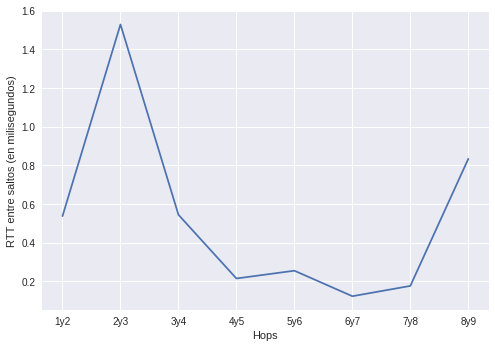

In [4]:
lstX = range(1, len(lstRttes)+1)
lstLabelX = []
for i in range(1, len(lstRttes)+1):
    lstLabelX.append(str(i)+'y'+str(i+1))

plt.plot(lstX, lstRttes)
plt.ylabel('RTT entre saltos (en milisegundos)')
plt.xlabel('Hops')
plt.xticks(range(1,len(lstRtt)), lstLabelX)
plt.show()

## RTT entre saltos en la ruta, graficar el valor (X i − X̄)/S

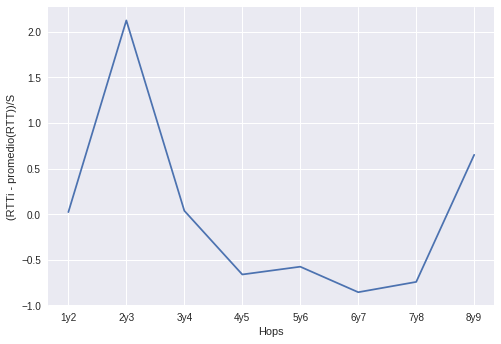

In [5]:
prom = promedio(lstRttes)
s = desvioEstandar(lstRttes)
lstVal = [(x-prom)/s for x in lstRttes]
lstX = range(1,len(lstRttes)+1)

lstLabelX = []
for i in range(1, len(lstRttes)+1):
    lstLabelX.append(str(i)+'y'+str(i+1))

plt.plot(lstX, lstVal)
plt.ylabel('(RTTi - promedio(RTT))/S')
plt.xlabel('Hops')
plt.xticks(range(1,len(lstX)+1), lstLabelX)
plt.show()

In [ ]:
prom = promedio(lstRttes)
s = desvioEstandar(lstRttes)
lstVal = [(x-prom)/s for x in lstRttes]
lstX = range(1,len(lstRttes)+1)

lstLabelX = []
for i in range(1, len(lstRttes)+1):
    lstLabelX.append(str(i)+'y'+str(i+1))

plt.plot(lstX, lstVal)
plt.ylabel('(RTTi - promedio(RTT))/S')
plt.xlabel('Hops')
plt.xticks(range(1,len(lstX)+1), lstLabelX)
plt.show()

## Porcentaje que no responden los Time exceeded

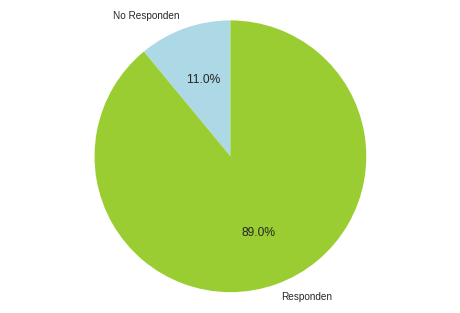

In [6]:
maxVal = max(set(dfAllHops['hop_num']))
lstTE = dfAllHops[dfAllHops['hop_num'] < maxVal]['ip_address']
cantNull = 0
for ip in lstTE:
    if ip == 'null':
        cantNull+=1

porcentajes = [cantNull, len(lstTE) - cantNull]

labels = 'No Responden', 'Responden'
explode = [0,0]

fig1, ax1 = plt.subplots()
ax1.pie(porcentajes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['lightblue', 'yellowgreen'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Cantidad de Ips por salto

In [7]:
hops = list(set(dfAllHops['hop_num']))
hops.sort()
lstSetIps = []
for h in hops:
    lstSetIps.append(set(dfAllHops[(dfAllHops['hop_num'] == h) & (dfAllHops['ip_address'] != 'null')]['ip_address']))

print lstSetIps
for s in lstSetIps:
    print len(s),

[set(['192.168.0.1']), set(['192.168.2.1']), set(['172.16.128.1']), set(['10.0.13.1']), set(['186.0.137.1']), set(['190.181.113.73']), set(['186.0.137.10']), set(['200.0.17.181']), set(['104.16.154.6', '104.16.151.6', '104.16.153.6', '104.16.155.6', '104.16.152.6'])]
1 1 1 1 1 1 1 1 5


## Saltos internacionales

In [8]:
print [dic['salto_intercontinental'] for dic in lstDic]

[u'false', u'false', True, u'false', u'false', u'false', u'false', u'false', True]
